In [58]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import xarray as xr
import os
from datetime import datetime, timedelta



In [64]:
year = '2022'
month = '07'
day = '02'

In [63]:
from dask.diagnostics import ProgressBar

# Define the base path and the subdirectory filter
base_path = '/storage/cdalden/goes/colorado/goes16/2022/7/2/ABI-L2-ACMC/'
valid_hours = [str(hour) for hour in range(16, 24)]  # Subdirectories ./20 through ./21

# Collect all .nc files in the valid subdirectories
nc_files = [
    os.path.join(root, file)
    for root, dirs, files in os.walk(base_path)
    for file in files
    if os.path.basename(root) in valid_hours and file.endswith('.nc')
]

# Sort the files to ensure proper time order
nc_files.sort()

# Use Dask for parallelized file reading and processing
with ProgressBar():  # Optional: Show progress bar for Dask operations
    combined_ds = xr.open_mfdataset(
        nc_files,
        concat_dim='t',  # Concatenate along 't' instead of 'time'
        combine='nested',
        preprocess=lambda ds: ds.expand_dims(t=[ds['t'].values]).drop_vars('time', errors='ignore'),
        parallel=True
    )

# Display the resulting dataset
combined_ds = combined_ds['ACM']
combined_ds = combined_ds.drop(['time', 'dem_px_angle_x', 'dem_px_angle_y'], errors='ignore')

combined_ds

[########################################] | 100% Completed | 10.67 ss
[########################################] | 100% Completed | 205.51 ms
[########################################] | 100% Completed | 102.65 ms
[########################################] | 100% Completed | 204.10 ms
[########################################] | 100% Completed | 204.92 ms
[########################################] | 100% Completed | 203.94 ms
[########################################] | 100% Completed | 204.13 ms
[########################################] | 100% Completed | 204.35 ms
[########################################] | 100% Completed | 106.91 ms
[########################################] | 100% Completed | 204.35 ms
[########################################] | 100% Completed | 104.13 ms
[########################################] | 100% Completed | 203.75 ms
[########################################] | 100% Completed | 102.67 ms
[########################################] | 100% Completed | 203

/tmp/ipykernel_3400135/3864743208.py:30: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  combined_ds = combined_ds.drop(['time', 'dem_px_angle_x', 'dem_px_angle_y'], errors='ignore')


<xarray.DataArray 'ACM' (t: 96, latitude: 1500, longitude: 2500)> Size: 1GB
dask.array<concatenate, shape=(96, 1500, 2500), dtype=float32, chunksize=(1, 1500, 2500), chunktype=numpy.ndarray>
Coordinates:
  * t          (t) datetime64[ns] 768B 2022-07-02T16:02:36.541504 ... 2022-07...
  * latitude   (latitude) float64 12kB 41.0 41.0 40.99 40.99 ... 37.01 37.0 37.0
  * longitude  (longitude) float64 20kB -109.0 -109.0 -109.0 ... -104.0 -104.0

In [65]:

# time = '16:02:00'

# path = '/storage/cdalden/goes/colorado/goes16/2023/2/6/ABI-L2-ACMC/20/'
# file = 'OR_ABI-L2-ACMC-M6_G16_s20230372001171_e20230372003544_c20230372005027_ortho.nc'
# ds = xr.open_dataset(path + file)

rgb_path = '/storage/cdalden/goes/colorado/goes16/rgb_composite/'
rgb_file = 'goes16_C02_C05_C13_rgb_colorado_{year}{month}{day}.nc'.format(year=year, month=month, day=day)
rgb_ds = xr.open_dataset(rgb_path + rgb_file)
# rgb_ds = rgb_ds.sel(t=(ds.t.values), method='nearest')
rgb_ds

<xarray.Dataset> Size: 4GB
Dimensions:    (t: 288, latitude: 640, longitude: 966)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2022-07-02T00:02:30 ... 2022-07-02T23:5...
  * latitude   (latitude) float64 5kB 41.0 40.99 40.99 ... 37.01 37.01 37.0
  * longitude  (longitude) float64 8kB -109.0 -109.0 -109.0 ... -104.0 -104.0
Data variables:
    green      (t, latitude, longitude) float32 712MB ...
    blue       (t, latitude, longitude) float64 1GB ...
    red        (t, latitude, longitude) float64 1GB ...

In [66]:
# Interpolate ds to the lower resolution of rgb_ds
ds_resampled = combined_ds.interp(
    latitude=rgb_ds.latitude,
    longitude=rgb_ds.longitude,
    t=rgb_ds.t
)

# Combine the two datasets along latitude, longitude, and time
new_ds = xr.merge([rgb_ds, ds_resampled])
new_ds = new_ds.dropna(dim='t', how='any')

new_ds


<xarray.Dataset> Size: 1GB
Dimensions:    (t: 95, latitude: 640, longitude: 966)
Coordinates:
  * t          (t) datetime64[ns] 760B 2022-07-02T16:07:30 ... 2022-07-02T23:...
  * latitude   (latitude) float64 5kB 41.0 40.99 40.99 ... 37.01 37.01 37.0
  * longitude  (longitude) float64 8kB -109.0 -109.0 -109.0 ... -104.0 -104.0
Data variables:
    green      (t, latitude, longitude) float32 235MB 0.1073 0.1073 ... 0.3659
    blue       (t, latitude, longitude) float64 470MB 0.3279 0.3279 ... 0.2372
    red        (t, latitude, longitude) float64 470MB 0.0 0.0 ... 0.5213 0.5213
    ACM        (t, latitude, longitude) float32 235MB dask.array<chunksize=(95, 64, 97), meta=np.ndarray>

Text(0.5, 1.0, 'GOES RGB Cloud Mask')

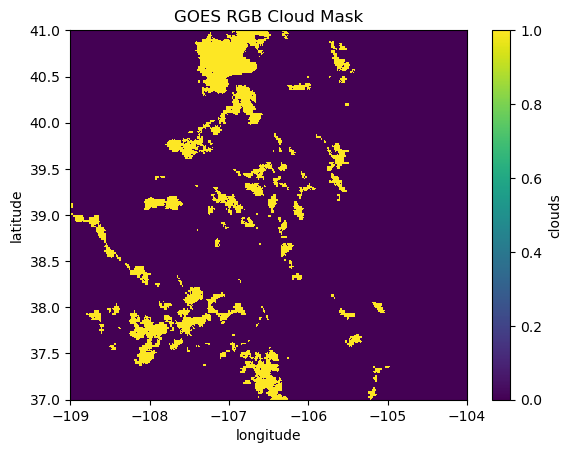

In [67]:
may_mask = ((new_ds.red <= 0.23) & (new_ds.blue >= 0.26) | ((new_ds.red > 0.23) & (new_ds.blue >= 0.16)))
summer_mask = (new_ds.red>0.07) & (new_ds.green>0.19)
winter_mask = (new_ds.red>0.39) & (new_ds.blue>0.13)
clouds = xr.where(summer_mask, 1, 0) # cloud (1) if all conds are met, not cloud (0) otherwise
new_ds['clouds'] = clouds
new_ds['goes_clouds'] = xr.where((new_ds['ACM'] == 3) | (new_ds['ACM'] == 2), 1, 0)


new_ds.sel(t='2022-07-02 17:00:00', method='nearest').clouds.plot.imshow(x='longitude', y='latitude')
plt.title('GOES RGB Cloud Mask')

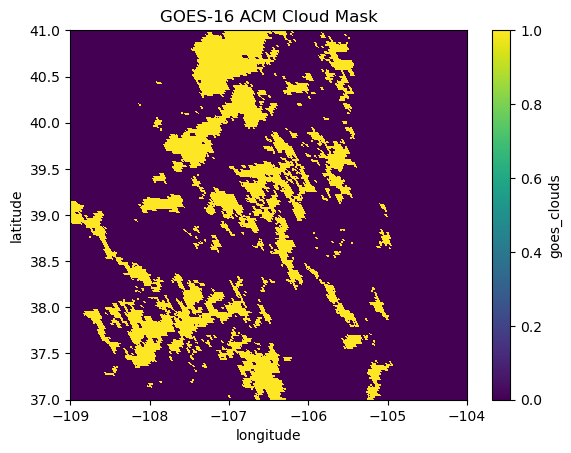

In [68]:


# ds['BCM'].plot.imshow(x='longitude', y='latitude', ax=ax, add_colorbar=True, cmap='viridis', robust=True)
new_ds.sel(t='2022-07-02 17:00:00', method='nearest').goes_clouds.plot.imshow(x='longitude', y='latitude')

plt.title("GOES-16 ACM Cloud Mask")
plt.show()

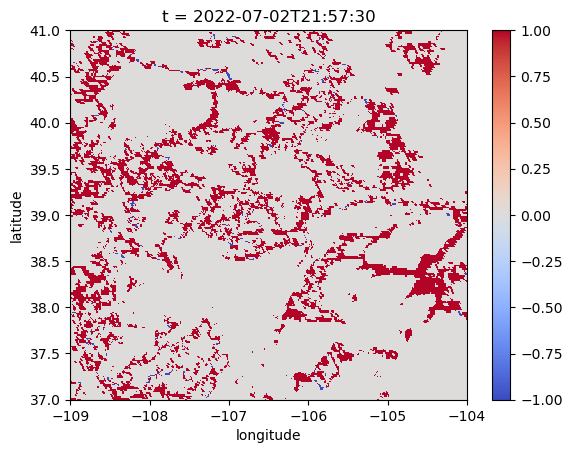

In [49]:
dif = new_ds.sel(t='2022-07-02 22:00:00', method='nearest').goes_clouds - new_ds.sel(t='2022-07-02 22:00:00', method='nearest').clouds

dif.plot.imshow(x='longitude', y='latitude', cmap='coolwarm')

In [52]:
dif = new_ds.goes_clouds - new_ds.clouds

dif.compute()
dif

<xarray.DataArray (t: 23, latitude: 640, longitude: 966)> Size: 114MB
dask.array<sub, shape=(23, 640, 966), dtype=int64, chunksize=(23, 128, 194), chunktype=numpy.ndarray>
Coordinates:
  * t          (t) datetime64[ns] 184B 2022-07-02T20:07:30 ... 2022-07-02T21:...
  * latitude   (latitude) float64 5kB 41.0 40.99 40.99 ... 37.01 37.01 37.0
  * longitude  (longitude) float64 8kB -109.0 -109.0 -109.0 ... -104.0 -104.0

In [62]:
import imageio

# Output GIF path
output_gif = "./gifs/goes_difference_plot_20220702.gif"

# Create a list to store the generated frames
frames = []
temp_files = []

# Loop through all timesteps in the dataset
for t in dif.t.values:
    # Parse the datetime object from the string
    dt = datetime.strptime(str(t).split(".")[0], "%Y-%m-%dT%H:%M:%S")
    
    # Subtract 2 minutes using timedelta
    adjusted_time = dt - timedelta(minutes=2)
    
    # Format the adjusted time back to the desired string format
    adjusted_time_str = adjusted_time.strftime("%Y%m%d %H:%M")
    
    print(f'working on {adjusted_time_str}')
    # Plot the difference
    fig, ax = plt.subplots(figsize=(8, 6))
    im = dif.sel(t=t).plot.imshow(x='longitude', y='latitude', cmap='coolwarm', ax=ax)

    ax.set_title(f"GOES ACM Mask minus RGB-derived mask\n{adjusted_time_str} UTC")
    
    # Sanitize the timestamp for the file name
    sanitized_t = str(t).replace(":", "-")
    temp_file = f"./plots/frame_{sanitized_t}.png"
    plt.savefig(temp_file)
    plt.close(fig)

    # Append the frame to the list
    frames.append(imageio.imread(temp_file))
    temp_files.append(temp_file)

# Save all frames as a GIF
imageio.mimsave(output_gif, frames, fps=10)  # Adjust FPS as needed

print(f"GIF saved to: {output_gif}")
# Delete temporary files
for temp_file in temp_files:
    os.remove(temp_file)
    print(f"Deleted: {temp_file}")

working on 20220702 20:05


/tmp/ipykernel_3400135/3674729065.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(temp_file))


working on 20220702 20:10
working on 20220702 20:15
working on 20220702 20:20
working on 20220702 20:25
working on 20220702 20:30
working on 20220702 20:35
working on 20220702 20:40
working on 20220702 20:45
working on 20220702 20:50
working on 20220702 20:55
working on 20220702 21:00
working on 20220702 21:05
working on 20220702 21:10
working on 20220702 21:15
working on 20220702 21:20
working on 20220702 21:25
working on 20220702 21:30
working on 20220702 21:35
working on 20220702 21:40
working on 20220702 21:45
working on 20220702 21:50
working on 20220702 21:55
GIF saved to: ./gifs/goes_difference_plot_20220702.gif
Deleted: ./plots/frame_2022-07-02T20-07-30.000000000.png
Deleted: ./plots/frame_2022-07-02T20-12-30.000000000.png
Deleted: ./plots/frame_2022-07-02T20-17-30.000000000.png
Deleted: ./plots/frame_2022-07-02T20-22-30.000000000.png
Deleted: ./plots/frame_2022-07-02T20-27-30.000000000.png
Deleted: ./plots/frame_2022-07-02T20-32-30.000000000.png
Deleted: ./plots/frame_2022-07-

In [40]:
# 1. Compute the difference map
difference_map = new_ds.clouds - new_ds.goes_clouds

# 2. Calculate performance metrics
clouds = new_ds.clouds.values.flatten()
bcm = new_ds.goes_clouds.values.flatten()

# True Positives, False Positives, True Negatives, False Negatives
tp = np.sum((clouds == 1) & (bcm == 1))
fp = np.sum((clouds == 1) & (bcm == 0))
tn = np.sum((clouds == 0) & (bcm == 0))
fn = np.sum((clouds == 0) & (bcm == 1))

# Metrics
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# 3. Plot the difference map
plt.figure(figsize=(10, 6))
difference_map.plot.imshow(cmap='coolwarm', add_colorbar=True)
plt.title("Difference Map (clouds - BCM)")

Accuracy: 0.85
Precision: 0.99
Recall: 0.76
F1 Score: 0.86


ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

<Figure size 1000x600 with 0 Axes>

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a list to store metrics for each timestep
metrics = []

# Loop over each timestep
for t in new_ds.t:
    # Select data for the current timestep
    clouds = new_ds.clouds.sel(t=t).values.flatten()
    bcm = new_ds.goes_clouds.sel(t=t).values.flatten()
    
    # Compute the difference map for the current timestep
    difference_map = new_ds.clouds.sel(t=t) - new_ds.goes_clouds.sel(t=t)
    
    # True Positives, False Positives, True Negatives, False Negatives
    tp = np.sum((clouds == 1) & (bcm == 1))
    fp = np.sum((clouds == 1) & (bcm == 0))
    tn = np.sum((clouds == 0) & (bcm == 0))
    fn = np.sum((clouds == 0) & (bcm == 1))
    
    # Metrics
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Append metrics for the current timestep
    metrics.append({
        't': t.values,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

# Convert metrics to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Display the metrics DataFrame
print(metrics_df)

                     t  accuracy  precision    recall  f1_score
0  2022-07-02 20:07:30  0.861500   0.987054  0.743490  0.848132
1  2022-07-02 20:12:30  0.860446   0.986901  0.747089  0.850412
2  2022-07-02 20:17:30  0.855093   0.986871  0.742636  0.847509
3  2022-07-02 20:22:30  0.851454   0.986642  0.742067  0.847054
4  2022-07-02 20:27:30  0.851571   0.987498  0.746373  0.850170
5  2022-07-02 20:32:30  0.850529   0.987468  0.748072  0.851259
6  2022-07-02 20:37:30  0.848332   0.985516  0.749617  0.851531
7  2022-07-02 20:42:30  0.847554   0.988385  0.750508  0.853176
8  2022-07-02 20:47:30  0.847585   0.987971  0.753774  0.855127
9  2022-07-02 20:52:30  0.848619   0.989198  0.757242  0.857816
10 2022-07-02 20:57:30  0.848044   0.989872  0.758885  0.859123
11 2022-07-02 21:02:30  0.847187   0.989500  0.760097  0.859759
12 2022-07-02 21:07:30  0.844811   0.991412  0.758564  0.859497
13 2022-07-02 21:12:30  0.843346   0.991956  0.758935  0.859940
14 2022-07-02 21:17:30  0.840740   0.992